In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dtw import *
from tqdm import tqdm

In [3]:
class DtwBacktest():
    # Start Date in terms of (YYYY-MM-DD) - if 0 will backtest with all available data
    def __init__(self, ticker, startDate=0):
        
        # Parameters to change to test - will mostly effect test time
        self.nPoints = 50
        self.trainPerc = 0.80
        self.predDataWinMove = 1
        self.histdataWinMove = 1 # Effects next day average - lower window moves give better averages
        
        # All costs below this cost compare value will be added to population
        # Will effect the win % the most
        self.costCompareValue = 0.5
        
        self.prediction = {"avgCost":[], 
                           "avgNextDay":[], "avgSnpNextDay":[], "actNextDay":[]}
        
        if startDate == 0:
            self.rawStockDf = yf.download(ticker,index=0)
            # Download SPY Data
            self.snpDf = yf.download('SPY', index=0)
        else:
            self.rawStockDf = yf.download(ticker, index=0, start=startDate)
            self.snpDf = yf.download('SPY', index=0, start=startDate)
        
        if self.rawStockDf.empty:
            print(f"Unable to get data for ticker: {ticker}")
            return 0
        
        # Reset to indices
        self.rawStockDf = self.rawStockDf.reset_index(drop=False)
        self.snpDf = self.snpDf.reset_index(drop=False)
        
        if startDate == 0:
            self.trimSnpDf(startDate)
        
        self.dtwAnalysis()
        
        self.addTradeResults()
        
    def trimSnpDf(self):

        maxIndex = self.snpDf.loc[self.snpDf["Date"] == self.rawStockDf["Date"].iat[-1]].index
        minIndex = self.snpDf.loc[self.snpDf["Date"] == self.rawStockDf["Date"].iat[0]].index
        # if base stock data goes farther back than other stock data then we will trim the main stock instead
        if(len(minIndex) == 0):
            minIndex = self.rawStockDf.loc[self.rawStockDf["Date"] == self.snpDf["Date"].iat[0]].index
            maxIndex = self.rawStockDf.loc[self.rawStockDf["Date"] == self.snpDf["Date"].iat[-1]].index

            self.rawStockDf = self.rawStockDf[minIndex.values[0]:maxIndex.values[0]]
            self.rawStockDf = self.rawStockDf.reset_index(drop=True)
        else:
            self.snpDf = self.snpDf[minIndex.values[0]:maxIndex.values[0]]
            self.snpDf = self.snpDf.reset_index(drop=True)
        
        
    def dtwAnalysis(self, rollAnalysis=True):
        
        self.histData, self.predictiveData = self.splitData()
        
        for i in tqdm(range(0, len(self.predictiveData)-self.nPoints-1, self.predDataWinMove)):
            # Grab data we want to compare with historical
            self.baseSignal = self.zeroSignal(np.array(self.predictiveData["Open"][i:i+self.nPoints]))
            
            self.dfAnalyzed = self.getRollingAnalysis()

            # Get actual Next Day Results
            actualNextDay = self.predictiveData.iloc[self.nPoints+i]
            
            self.refineResults(actualNextDay)
            
        self.dfPrediction = pd.DataFrame.from_dict(self.prediction)
        
    def splitData(self):
        df = self.rawStockDf
        histData = df[int(len(df)*(1-self.trainPerc)):]
        predictiveData = df[0:int(len(df)*(1-self.trainPerc))]
        
        histData = histData.reset_index()
        predictiveData = predictiveData.reset_index()
        
        return histData, predictiveData
        
    def concatData(self, i):
        
        # Grab window of data to append to the top of the training data
        df = self.trainData[0+i:self.nPoints+i]
        
        # Grab next days data to compare results with
        self.actualNextDay = self.trainData.iloc[self.nPoints+i]
        
        frames = [df, self.predictiveData]
        predicitingData = pd.concat(frames)
        
        return predicitingData.reset_index(drop=False)
        
    def getRollingAnalysis(self):
        
        # Create new data frame that will hold indexes, dtw values, and gains next n days
        rollingDict = {"indexStart":[], "indexEnd":[], "totalCost":[], 
                       "nextDay":[], "snpNextDay":[]}
        
        for j in range(0,int(len(self.histData)-2*self.nPoints),self.histdataWinMove):
            # Take next index range and adjust to be percent
            compareSignal = self.zeroSignal(np.array(self.histData["Open"][j:j+self.nPoints]))
            snpSignal = self.zeroSignal(np.array(self.histData["Open"][j:j+self.nPoints]))
            
            # Get DTW values
            self.getDtw(self.baseSignal,compareSignal)
            
            # Get sum of path of least cost
            sumPath = self.getSumPath()
            if (sumPath < self.costCompareValue):
                rollingDict["indexStart"].append(j)
                rollingDict["indexEnd"].append(j+self.nPoints)
                rollingDict["totalCost"].append(sumPath)
                rollingDict["nextDay"].append(1-(self.histData["Open"][j+self.nPoints+1]/self.histData["Close"][j+self.nPoints+1]))
                rollingDict["snpNextDay"].append(1-(self.snpDf["Open"][j+self.nPoints+1]/self.snpDf["Close"][j+self.nPoints+1]))
                
        return pd.DataFrame.from_dict(rollingDict)
    
        
    def getSumPath(self):
        sumPath = 0
        for i in range(len(self.path[0])):
            sumPath = sumPath + self.cost_matrix[self.path[0][i]][self.path[1][i]]
        
        return sumPath
    
    def zeroSignal(self, signal):
        return signal/signal[0]
    
    def createWindow(self, window):
        lowBound = int(len(self.cutDataDf)/window)
        # Lower Bound closest number
        closestLowBound = lowBound * window
        
        df = self.cutDataDf.drop(np.arange(len(self.cutDataDf)-closestLowBound),axis=0)
        df = df.reset_index(drop=False)
        
        return df
        
    def getDtw(self, baseSignal, compareSignal):
        norm_12 = lambda baseSignal, compareSignal:(baseSignal-compareSignal)**2
        dist,cost_matrix,acc_cost_matrix,path = dtw(baseSignal,compareSignal,norm_12)
        
        self.cost_matrix = cost_matrix
        self.acc_cost_matrix = acc_cost_matrix
        self.path = path
        self.dist = dist
        
    def refineResults(self, actualNextDay):
        df = self.dfAnalyzed

        # get avg cost and next day percent gain from dtwAnalysis
        self.prediction["avgCost"].append(sum(df["totalCost"])/len(df["totalCost"]))
        self.prediction["avgNextDay"].append(sum(df["nextDay"])/len(df["nextDay"]))
        self.prediction["avgSnpNextDay"].append(sum(df["snpNextDay"])/len(df["snpNextDay"]))
        self.prediction["actNextDay"].append(float(1-(actualNextDay["Open"]/actualNextDay["Close"])))
        
    def addTradeResults(self):
        df = self.prediction
        
        sumOfCorrect = 0
        totalGuesses = 0
        buyAmount = 1000
        
        self.profit = 0
        self.winPerc = 0
        self.totalGuesses = 0
        self.sumOfCorrect = 0
        

        
        for i in range(len(self.dfPrediction)):
            if self.dfPrediction["avgNextDay"][i]>=0 and self.dfPrediction["avgSnpNextDay"][i] >= 0:
                self.profit = self.profit+buyAmount*self.dfPrediction["actNextDay"][i]
                self.totalGuesses = self.totalGuesses + 1
                if self.dfPrediction["actNextDay"][i] > 0:
                    self.sumOfCorrect = self.sumOfCorrect + 1
        
        if self.totalGuesses == 0 or self.sumOfCorrect == 0:
            self.winPerc = 0
        else:
            self.winPerc = self.sumOfCorrect/self.totalGuesses
            

In [12]:
class PlottingFuncs(DtwBacktest):
    def __init__(self, baseSignal, compareSignal):
        self.baseSignal = np.array(baseSignal)
        self.compareSignal = np.array(compareSignal)
        
        self.baseSignal = (self.baseSignal/self.baseSignal[0])
        self.compareSignal = (self.compareSignal/self.compareSignal[0])
        
        
        self.getDtw(self.baseSignal, self.compareSignal)
        
    def plotMatrix(self):
        plt.figure(figsize=(10, 10), dpi=80)
        plt.imshow(self.acc_cost_matrix.T, origin='lower', cmap='gray', interpolation='nearest')
        plt.plot(self.path[0], self.path[1], 'w')
        plt.show()
        
    def plotCostMatrix(self):
        min_val = 0
        max_val = 20
        fig, ax = plt.subplots()
        fig.set_size_inches(15,15)

        for i in range(len(self.cost_matrix)):
            for j in range(len(self.cost_matrix)):
                c = round((self.cost_matrix[i][j]),3)
                ax.text(i+0.5, j+0.5, str(c), va='center', ha='center')

        ax.set_xlim(min_val, max_val)
        ax.set_ylim(min_val, max_val)
        ax.set_xticks(np.arange(max_val))
        ax.set_yticks(np.arange(max_val))
        ax.grid()
        
    def plotStockComparison(self):
        plt.figure(figsize=(10,10))
        baseAxis = np.arange(len(self.baseSignal))
        compareAxis = np.arange(len(self.compareSignal))
        plt.plot(baseAxis,self.baseSignal)
        plt.plot(compareAxis,self.compareSignal)
        
    def plotCost2Return(self, df):
        plt.figure(figsize=(15,15))
        cost = np.array(df['totalCost'])
        returns = np.array(df['nextDay'])
        ax1 = plt.scatter(cost,returns)
        plt.axhline(y=0,color='r',linestyle='-')
        plt.grid(True)
        plt.xlabel('DtwTotalCost')
        plt.ylabel('Returns (%)')
        plt.xlim([0, 1.5])

In [8]:
def backtest(results, tickerArr):
    for i in tickerArr:
        try:
            stock = DtwBacktest(i, startDate='2018-01-01')
            results['Ticker'].append(i)
            results['profit'].append(stock.profit)
            results['winPerc'].append(stock.winPerc)
            results['totalGuess'].append(stock.totalGuesses)
            results['sumOfCorrect'].append(stock.sumOfCorrect)
        except:
            pass
    return results

In [9]:
tickerArray = [
    'TSLA'
]

In [10]:
results = {'Ticker':[],'profit':[],'winPerc':[], 'totalGuess':[], 'sumOfCorrect':[]}
results = backtest(results, tickerArray)
results = pd.DataFrame.from_dict(results)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


100%|█████████████████████████████████████████| 188/188 [20:41<00:00,  6.60s/it]


In [11]:
results

,Ticker,profit,winPerc,totalGuess,sumOfCorrect
0,TSLA,-13.886016,0.6,5,3


In [15]:
stockTest = DtwBacktest('TSLA',startDate='2018-01-01')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


100%|█████████████████████████████████████████| 188/188 [19:23<00:00,  6.19s/it]


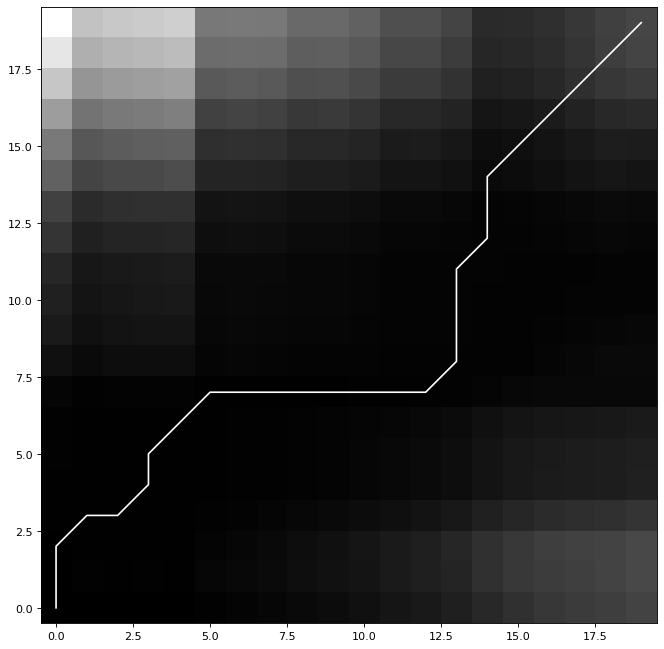

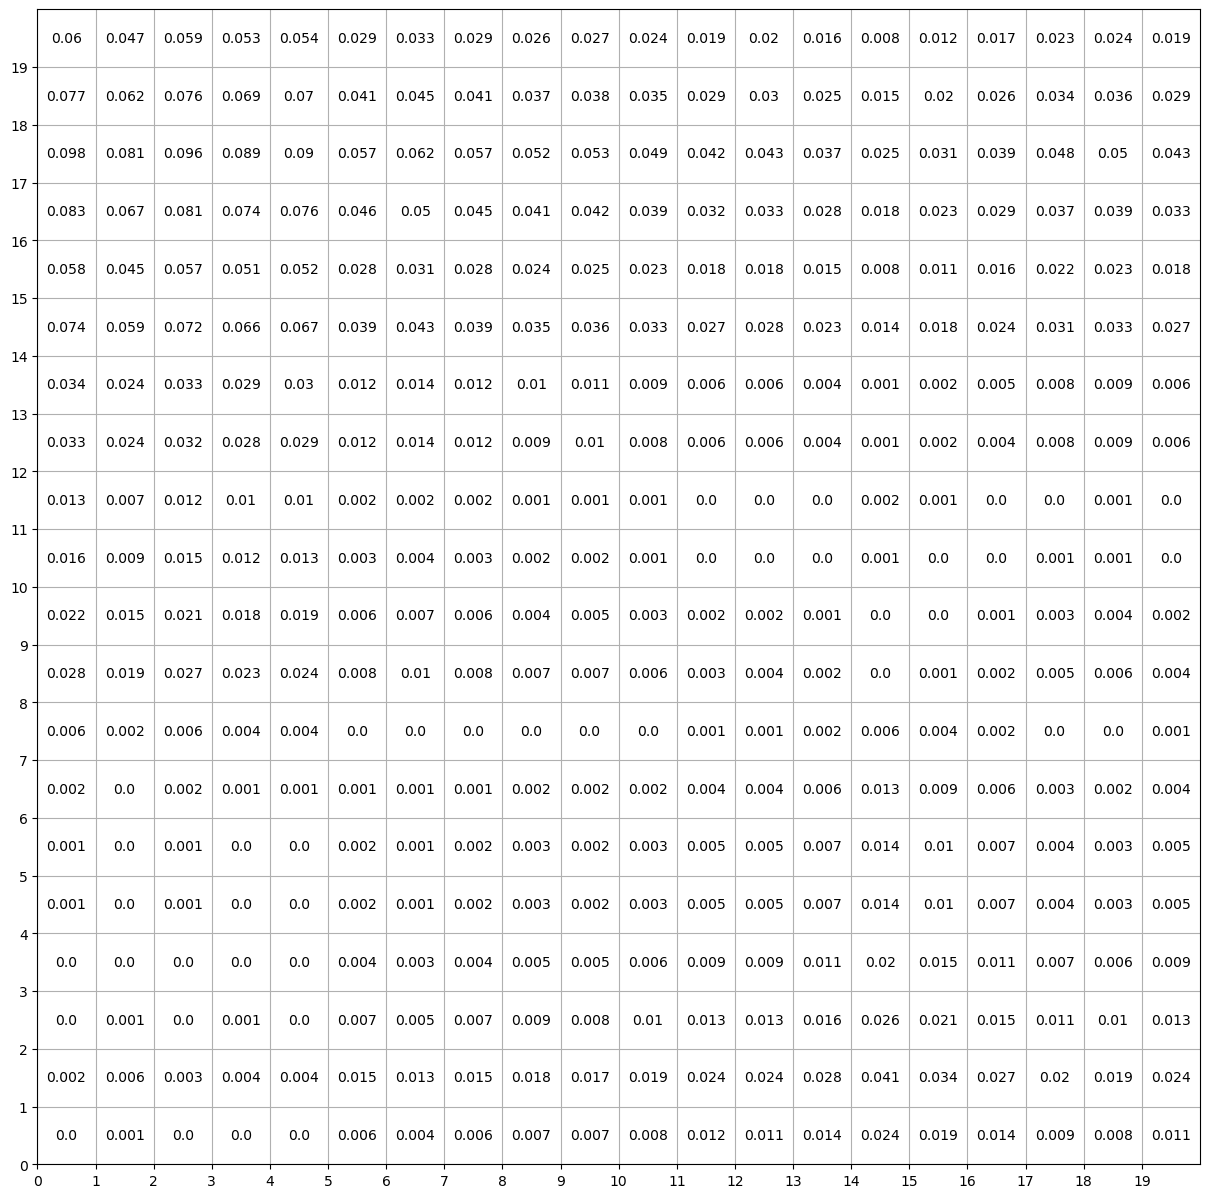

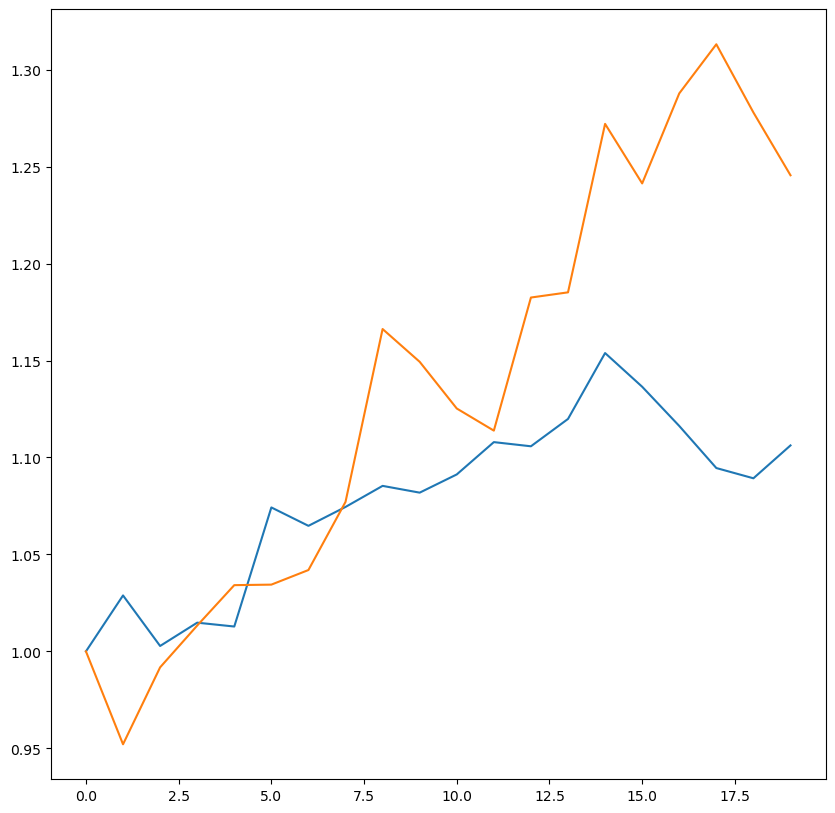

In [17]:
plots = PlottingFuncs(stockTest.rawStockDf['Open'].head(20), stockTest.rawStockDf['Open'][len(stockTest.rawStockDf)-60:len(stockTest.rawStockDf)-40])
plots.plotMatrix()
plots.plotCostMatrix()
plots.plotStockComparison()